# Business understanding

Generator planet 
- format wejściowy plików:  1920px/1080px
- format wyjściowy plików:  64px/64px

In [1]:
# import niezbednych bibliotek
import os
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from keras.models import load_model

In [2]:
# wersja tensorflow
print('tensorflow ver: ', tf.__version__)
print('keras ver     : ', tf.keras.__version__)

tensorflow ver:  2.10.1
keras ver     :  2.10.0


# Data understanding and data preparation

Dataset zrobiony z modeli udostępnionych przez NASA na stronie: nasa.gov
- 12 planet/gwiazd
- 100 zdjęć na planetę/gwiazde

In [3]:
dir_directory_path = './DATA/v1'

images_data = []
images_labels = []
    
subfolders = [ f.path for f in os.scandir(dir_directory_path) if f.is_dir() ]

for dir_path in subfolders:
    print('Loading data from folder', dir_path.replace("\\", "/"))

    dataset = tf.keras.preprocessing.image_dataset_from_directory(
                dir_path, 
                label_mode=None, 
                image_size=(64, 114), 
                batch_size=32,
                #color_mode='grayscale'
            )
    
    for i in dataset:
        for ii in i:            
            new_img = ii[0:64, 25:89]
            images_data.append(new_img)
            images_labels.append(dir_path.replace(dir_directory_path, '').replace('\\',''))
                        
images_data = np.asarray(images_data)
images_labels = np.asarray(images_labels)

new_images_data = []
new_images_labels = []

for idx in range(0, images_data.shape[0]):
    img = Image.fromarray(np.uint8(images_data[idx]))
    class_name = images_labels[idx]
    
    new_images_data.append(np.asarray(img))
    new_images_labels.append(class_name)
    
    for i in range(180, 360, 180):
        rotated_img = img.rotate(i)
        new_images_data.append(np.asarray(rotated_img))
        new_images_labels.append(class_name)
                        
images_data = np.asarray(new_images_data)
images_labels = np.asarray(new_images_labels)        

label_encoder = LabelEncoder()
images_labels_num = label_encoder.fit_transform(images_labels)

print()
print('Shapes:')
print('images_labels      :', images_labels.shape)
print('-----------------------------')
print('images_data        :', images_data.shape)
print('images_labels_num  :', images_labels_num.shape)

Loading data from folder ./DATA/v1/ceres
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/earth
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/earth_moon
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/eris
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/hamuea
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/jupiter
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/makemake
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/mars
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/mercury
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/pluto
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/sun
Found 100 files belonging to 1 classes.
Loading data from folder ./DATA/v1/venus
Found 100 files belonging to 1 classes.

Shapes:
images_lab

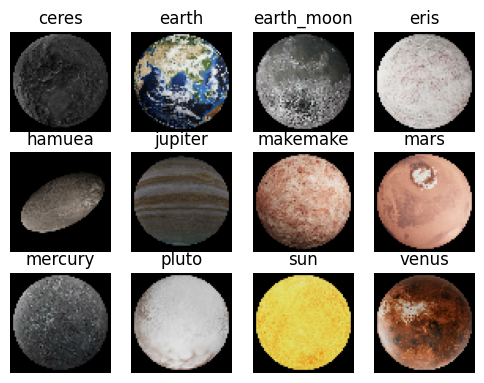

In [7]:
np.random.seed(100)

idx = 0
fig = plt.figure(figsize=(6, 6))
for i in np.unique(images_labels_num):    
    idx += 1
    class_position = np.where(images_labels_num  == i)[0]
    class_position = np.random.choice(class_position)
    plt.subplot(4, 4, idx)
    plt.imshow(images_data[class_position] / 255.)
    plt.title(images_labels[class_position])    
    plt.axis('off')
plt.show()
plt.close(fig)    

In [8]:
train_images = images_data
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

train_images.shape

(2400, 64, 64, 3)

# Modeling

In [9]:
# latent dimension of the random noise
LATENT_DIM = 100 
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 3 # UPDATED from 1

In [20]:
def build_generator(image_size):
    
    size = int(image_size / 4)
    
    # create a Keras Sequential model 
    model = Sequential(name='generator')

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
    model.add(layers.Dense(size * size * 256, input_dim=LATENT_DIM))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    
    # 1D => 3D: reshape the output of the previous layer 
    model.add(layers.Reshape((size, size, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False, kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False, kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())    
    model.add(layers.LeakyReLU())

    # last layer 
    model.add(layers.Conv2DTranspose(CHANNELS, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"))
        
    return model     


# build the generator model
generator = build_generator(64) 
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 65536)             6619136   
                                                                 
 batch_normalization_3 (Batc  (None, 65536)            262144    
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 65536)             0         
                                                                 
 reshape_1 (Reshape)         (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 16, 16, 128)      819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 128)      51

c:\APLIKACJE\PyDataScience\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [21]:
def build_discriminator(height, width, depth, alpha=0.2):
    # create a Keras Sequential model
    model = Sequential(name='discriminator')
    input_shape = (height, width, depth)

    # 1. first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(128, (3, 3), padding="same", strides=(2, 2), input_shape=input_shape))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.3))
    
    # 2. second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(64, (3, 3), padding="same", strides=(2, 2)))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.3))
    
    # flatten and apply dropout
    model.add(layers.Flatten())
    #model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation="sigmoid"))

    # return the discriminator model
    return model


# build the discriminator model
discriminator = build_discriminator(64, 64, 3) 
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        73792     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 16384)           

In [22]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            real_labels = tf.ones((batch_size, 1))
            # UPDATED: apply one-sided label smoothing to real labels
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels)) 
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros((batch_size, 1))
            # UPDATED: add random noise to fake labels - not needed
            # fake_labels += 0.05 * tf.random.uniform(tf.shape(fake_labels)) 
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        misleading_labels = tf.ones((batch_size, 1)) # G wants D to think the fake images are real (label as 1)

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator wieghts
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}  

In [23]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during traing
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(3, 3))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img)
            plt.axis('off')
        plt.savefig('./results_064_v2/epoch_{:03d}.jpg'.format(epoch + 1)) 
        if epoch == 0 or epoch % 10 == 0:
            plt.show()
        plt.close(fig)
                
        for i in range(self.num_img):
            fig = plt.figure(figsize=(1, 1))
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img)
            plt.axis('off')
            plt.savefig('./results_064_v2/images/epoch_{:03d}_img_{:03d}.jpg'.format(epoch + 1, i + 1)) 
            plt.close(fig)
        if epoch == 0 or epoch % 5 == 0:
            self.model.generator.save('./results_064_v2/generator_{:03d}.h5'.format(epoch + 1))

    def on_train_end(self, logs=None):
        self.model.generator.save('./results_064_v2/generator_last.h5')

In [24]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

D_LR = 0.0001 # UPDATED: discriminator learning rate
G_LR = 0.0003 # UPDATED: generator learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=D_LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=G_LR, beta_1 = 0.5),  
    loss_fn=keras.losses.BinaryCrossentropy(),
)

# Evaluation

Epoch 1/500
75/75 [==============================] - ETA: 0s - d_loss: 0.2478 - g_loss: 0.0728

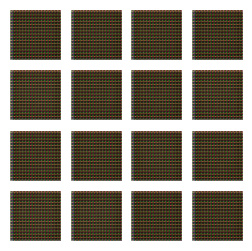

75/75 [==============================] - 27s 352ms/step - d_loss: 0.2478 - g_loss: 0.0728
Epoch 2/500
75/75 [==============================] - 27s 361ms/step - d_loss: -0.5297 - g_loss: 4.6805e-07
Epoch 3/500
75/75 [==============================] - 31s 416ms/step - d_loss: -4.4290 - g_loss: 2.1904e-26
Epoch 4/500
75/75 [==============================] - 30s 395ms/step - d_loss: -17.9184 - g_loss: 0.0000e+00
Epoch 5/500
75/75 [==============================] - 30s 398ms/step - d_loss: -46.3893 - g_loss: 0.0000e+00
Epoch 6/500
75/75 [==============================] - 30s 393ms/step - d_loss: -90.0639 - g_loss: 0.0000e+00
Epoch 7/500
75/75 [==============================] - 29s 387ms/step - d_loss: -44.0950 - g_loss: 0.0152
Epoch 8/500
75/75 [==============================] - 29s 392ms/step - d_loss: 3815.2129 - g_loss: 0.0000e+00
Epoch 9/500
75/75 [==============================] - 29s 381ms/step - d_loss: 997.9033 - g_loss: 0.0000e+00
Epoch 10/500
75/75 [==============================]

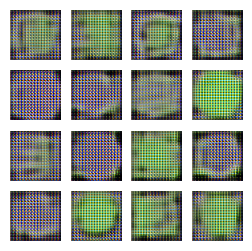

75/75 [==============================] - 29s 383ms/step - d_loss: 497.7968 - g_loss: 2.7500
Epoch 12/500
75/75 [==============================] - 29s 386ms/step - d_loss: 391.4855 - g_loss: 0.1512
Epoch 13/500
75/75 [==============================] - 29s 382ms/step - d_loss: 265.3195 - g_loss: 1.3717
Epoch 14/500
75/75 [==============================] - 29s 384ms/step - d_loss: 70.3232 - g_loss: 3.9457
Epoch 15/500
75/75 [==============================] - 29s 386ms/step - d_loss: 23.2996 - g_loss: 0.2346
Epoch 16/500
75/75 [==============================] - 29s 383ms/step - d_loss: 65.5709 - g_loss: 2.0500
Epoch 17/500
75/75 [==============================] - 29s 383ms/step - d_loss: 72.7797 - g_loss: 1.4743
Epoch 18/500
75/75 [==============================] - 29s 384ms/step - d_loss: 54.5566 - g_loss: 0.8780
Epoch 19/500
75/75 [==============================] - 29s 388ms/step - d_loss: 51.7553 - g_loss: 2.4881
Epoch 20/500
75/75 [==============================] - 29s 385ms/step - d_l

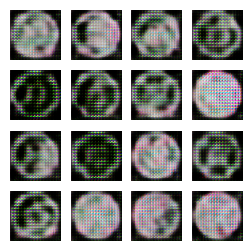

75/75 [==============================] - 29s 387ms/step - d_loss: 28.8579 - g_loss: 1.6450
Epoch 22/500
75/75 [==============================] - 29s 393ms/step - d_loss: 25.6363 - g_loss: 1.5974
Epoch 23/500
75/75 [==============================] - 29s 390ms/step - d_loss: 23.5509 - g_loss: 2.8825
Epoch 24/500
75/75 [==============================] - 29s 384ms/step - d_loss: 24.3935 - g_loss: 4.3379
Epoch 25/500
75/75 [==============================] - 29s 384ms/step - d_loss: 22.2788 - g_loss: 4.3987
Epoch 26/500
75/75 [==============================] - 29s 385ms/step - d_loss: 20.3356 - g_loss: 5.0525
Epoch 27/500
75/75 [==============================] - 29s 383ms/step - d_loss: 20.4585 - g_loss: 5.2479
Epoch 28/500
75/75 [==============================] - 29s 383ms/step - d_loss: 19.6815 - g_loss: 5.1482
Epoch 29/500
75/75 [==============================] - 29s 382ms/step - d_loss: 20.3332 - g_loss: 4.4849
Epoch 30/500
75/75 [==============================] - 29s 386ms/step - d_loss

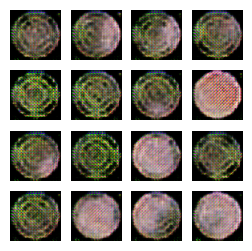

75/75 [==============================] - 29s 385ms/step - d_loss: 19.6853 - g_loss: 4.5366
Epoch 32/500
75/75 [==============================] - 29s 383ms/step - d_loss: 19.3585 - g_loss: 4.6311
Epoch 33/500
75/75 [==============================] - 29s 383ms/step - d_loss: 18.5044 - g_loss: 4.8082
Epoch 34/500
75/75 [==============================] - 29s 384ms/step - d_loss: 18.0680 - g_loss: 5.2838
Epoch 35/500
75/75 [==============================] - 29s 388ms/step - d_loss: 17.1285 - g_loss: 5.3396
Epoch 36/500
75/75 [==============================] - 29s 386ms/step - d_loss: 17.1584 - g_loss: 4.6258
Epoch 37/500
75/75 [==============================] - 29s 386ms/step - d_loss: 16.5978 - g_loss: 4.5979
Epoch 38/500
75/75 [==============================] - 29s 388ms/step - d_loss: 15.5331 - g_loss: 4.9181
Epoch 39/500
75/75 [==============================] - 29s 385ms/step - d_loss: 15.5708 - g_loss: 5.0132
Epoch 40/500
75/75 [==============================] - 29s 384ms/step - d_loss

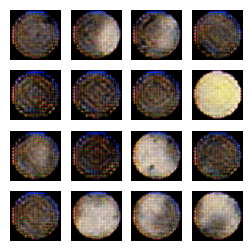

75/75 [==============================] - 29s 385ms/step - d_loss: 14.5833 - g_loss: 4.8345
Epoch 42/500
75/75 [==============================] - 29s 389ms/step - d_loss: 13.4629 - g_loss: 4.5272
Epoch 43/500
75/75 [==============================] - 29s 386ms/step - d_loss: 12.9029 - g_loss: 4.1444
Epoch 44/500
75/75 [==============================] - 29s 386ms/step - d_loss: 13.0718 - g_loss: 4.9208
Epoch 45/500
75/75 [==============================] - 29s 388ms/step - d_loss: 12.7859 - g_loss: 5.0210
Epoch 46/500
75/75 [==============================] - 29s 386ms/step - d_loss: 12.3760 - g_loss: 4.2714
Epoch 47/500
75/75 [==============================] - 29s 387ms/step - d_loss: 11.0444 - g_loss: 4.5693
Epoch 48/500
75/75 [==============================] - 29s 389ms/step - d_loss: 10.5635 - g_loss: 4.7646
Epoch 49/500
75/75 [==============================] - 29s 387ms/step - d_loss: 10.6352 - g_loss: 4.4238
Epoch 50/500
75/75 [==============================] - 29s 387ms/step - d_loss

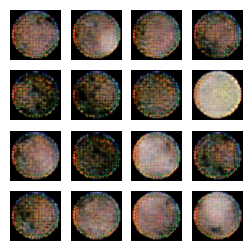

75/75 [==============================] - 29s 388ms/step - d_loss: 10.2455 - g_loss: 4.2130
Epoch 52/500
75/75 [==============================] - 29s 387ms/step - d_loss: 9.1562 - g_loss: 4.2893
Epoch 53/500
75/75 [==============================] - 29s 391ms/step - d_loss: 9.3735 - g_loss: 4.2003
Epoch 54/500
75/75 [==============================] - 29s 386ms/step - d_loss: 9.0491 - g_loss: 3.9816
Epoch 55/500
75/75 [==============================] - 29s 387ms/step - d_loss: 8.9636 - g_loss: 4.0861
Epoch 56/500
75/75 [==============================] - 29s 389ms/step - d_loss: 8.3034 - g_loss: 4.0479
Epoch 57/500
75/75 [==============================] - 29s 386ms/step - d_loss: 8.0814 - g_loss: 4.0236
Epoch 58/500
75/75 [==============================] - 31s 417ms/step - d_loss: 8.0120 - g_loss: 4.0796
Epoch 59/500
75/75 [==============================] - 29s 392ms/step - d_loss: 7.5302 - g_loss: 3.6045
Epoch 60/500
75/75 [==============================] - 30s 395ms/step - d_loss: 7.9070

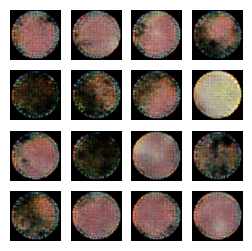

75/75 [==============================] - 30s 396ms/step - d_loss: 7.1488 - g_loss: 3.4343
Epoch 62/500
75/75 [==============================] - 30s 397ms/step - d_loss: 6.9678 - g_loss: 3.5223
Epoch 63/500
75/75 [==============================] - 30s 396ms/step - d_loss: 6.9644 - g_loss: 3.4958
Epoch 64/500
75/75 [==============================] - 30s 402ms/step - d_loss: 6.3220 - g_loss: 3.4252
Epoch 65/500
75/75 [==============================] - 30s 396ms/step - d_loss: 6.6490 - g_loss: 3.2728
Epoch 66/500
75/75 [==============================] - 30s 395ms/step - d_loss: 6.4606 - g_loss: 3.4431
Epoch 67/500
75/75 [==============================] - 30s 399ms/step - d_loss: 6.4649 - g_loss: 3.3220
Epoch 68/500
75/75 [==============================] - 30s 398ms/step - d_loss: 5.9699 - g_loss: 3.4403
Epoch 69/500
75/75 [==============================] - 30s 398ms/step - d_loss: 5.8298 - g_loss: 3.0755
Epoch 70/500
75/75 [==============================] - 30s 399ms/step - d_loss: 5.2073 

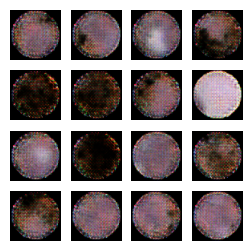

75/75 [==============================] - 30s 402ms/step - d_loss: 5.3844 - g_loss: 3.0584
Epoch 72/500
75/75 [==============================] - 30s 398ms/step - d_loss: 5.1920 - g_loss: 3.2088
Epoch 73/500
75/75 [==============================] - 30s 398ms/step - d_loss: 5.2935 - g_loss: 3.0415
Epoch 74/500
75/75 [==============================] - 30s 397ms/step - d_loss: 4.7499 - g_loss: 2.7401
Epoch 75/500
75/75 [==============================] - 30s 398ms/step - d_loss: 4.6944 - g_loss: 2.7536
Epoch 76/500
75/75 [==============================] - 30s 403ms/step - d_loss: 4.3426 - g_loss: 2.3764
Epoch 77/500
75/75 [==============================] - 30s 399ms/step - d_loss: 4.4872 - g_loss: 2.6117
Epoch 78/500
75/75 [==============================] - 29s 394ms/step - d_loss: 4.4408 - g_loss: 2.9187
Epoch 79/500
75/75 [==============================] - 30s 398ms/step - d_loss: 4.8725 - g_loss: 2.7649
Epoch 80/500
75/75 [==============================] - 30s 399ms/step - d_loss: 4.3442 

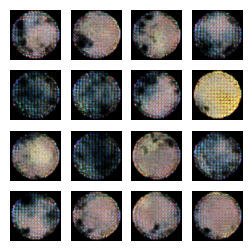

75/75 [==============================] - 30s 400ms/step - d_loss: 4.1645 - g_loss: 2.6823
Epoch 82/500
75/75 [==============================] - 31s 411ms/step - d_loss: 4.2793 - g_loss: 2.6152
Epoch 83/500
75/75 [==============================] - 30s 398ms/step - d_loss: 4.0602 - g_loss: 2.5908
Epoch 84/500
75/75 [==============================] - 30s 401ms/step - d_loss: 4.3124 - g_loss: 2.7160
Epoch 85/500
75/75 [==============================] - 30s 395ms/step - d_loss: 3.9126 - g_loss: 2.6893
Epoch 86/500
75/75 [==============================] - 29s 393ms/step - d_loss: 3.6980 - g_loss: 2.5894
Epoch 87/500
75/75 [==============================] - 29s 393ms/step - d_loss: 3.8491 - g_loss: 2.2776
Epoch 88/500
75/75 [==============================] - 30s 395ms/step - d_loss: 3.5158 - g_loss: 2.4425
Epoch 89/500
75/75 [==============================] - 30s 395ms/step - d_loss: 3.6359 - g_loss: 2.3874
Epoch 90/500
75/75 [==============================] - 30s 395ms/step - d_loss: 3.6889 

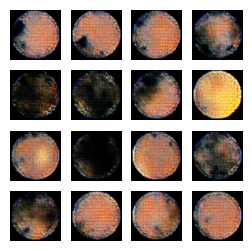

75/75 [==============================] - 31s 407ms/step - d_loss: 3.2540 - g_loss: 2.0188
Epoch 92/500
75/75 [==============================] - 30s 405ms/step - d_loss: 3.4501 - g_loss: 2.2446
Epoch 93/500
75/75 [==============================] - 30s 396ms/step - d_loss: 3.4080 - g_loss: 2.1187
Epoch 94/500
75/75 [==============================] - 30s 397ms/step - d_loss: 3.2977 - g_loss: 2.1572
Epoch 95/500
75/75 [==============================] - 29s 392ms/step - d_loss: 3.1551 - g_loss: 2.0924
Epoch 96/500
75/75 [==============================] - 30s 395ms/step - d_loss: 3.1435 - g_loss: 2.1676
Epoch 97/500
75/75 [==============================] - 29s 392ms/step - d_loss: 2.9020 - g_loss: 1.9576
Epoch 98/500
75/75 [==============================] - 29s 391ms/step - d_loss: 3.0854 - g_loss: 1.8407
Epoch 99/500
75/75 [==============================] - 30s 402ms/step - d_loss: 2.8950 - g_loss: 1.9408
Epoch 100/500
75/75 [==============================] - 30s 393ms/step - d_loss: 2.5765

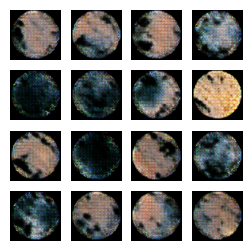

75/75 [==============================] - 29s 388ms/step - d_loss: 2.8373 - g_loss: 1.8179
Epoch 102/500
75/75 [==============================] - 29s 385ms/step - d_loss: 2.7163 - g_loss: 1.6450
Epoch 103/500
75/75 [==============================] - 29s 385ms/step - d_loss: 2.5456 - g_loss: 1.7182
Epoch 104/500
75/75 [==============================] - 29s 385ms/step - d_loss: 2.7899 - g_loss: 1.7476
Epoch 105/500
75/75 [==============================] - 29s 391ms/step - d_loss: 2.5277 - g_loss: 1.7822
Epoch 106/500
75/75 [==============================] - 29s 387ms/step - d_loss: 2.6738 - g_loss: 1.8352
Epoch 107/500
75/75 [==============================] - 29s 387ms/step - d_loss: 2.4565 - g_loss: 1.6080
Epoch 108/500
75/75 [==============================] - 29s 386ms/step - d_loss: 2.4763 - g_loss: 1.6186
Epoch 109/500
75/75 [==============================] - 29s 389ms/step - d_loss: 2.3219 - g_loss: 1.5372
Epoch 110/500
75/75 [==============================] - 29s 387ms/step - d_loss

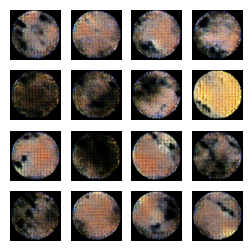

75/75 [==============================] - 29s 388ms/step - d_loss: 2.2257 - g_loss: 1.6075
Epoch 112/500
75/75 [==============================] - 29s 387ms/step - d_loss: 2.0810 - g_loss: 1.5002
Epoch 113/500
75/75 [==============================] - 30s 400ms/step - d_loss: 2.1686 - g_loss: 1.6001
Epoch 114/500
75/75 [==============================] - 30s 398ms/step - d_loss: 2.1165 - g_loss: 1.5544
Epoch 115/500
75/75 [==============================] - 30s 398ms/step - d_loss: 2.1083 - g_loss: 1.3902
Epoch 116/500
75/75 [==============================] - 30s 399ms/step - d_loss: 1.9897 - g_loss: 1.4535
Epoch 117/500
75/75 [==============================] - 30s 398ms/step - d_loss: 1.9757 - g_loss: 1.4293
Epoch 118/500
75/75 [==============================] - 30s 397ms/step - d_loss: 1.8230 - g_loss: 1.3708
Epoch 119/500
75/75 [==============================] - 30s 395ms/step - d_loss: 1.8285 - g_loss: 1.3116
Epoch 120/500
75/75 [==============================] - 30s 401ms/step - d_loss

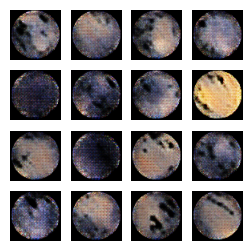

75/75 [==============================] - 30s 400ms/step - d_loss: 1.7925 - g_loss: 1.2464
Epoch 122/500
75/75 [==============================] - 30s 398ms/step - d_loss: 1.7717 - g_loss: 1.2952
Epoch 123/500
75/75 [==============================] - 30s 399ms/step - d_loss: 1.7971 - g_loss: 1.2251
Epoch 124/500
75/75 [==============================] - 30s 397ms/step - d_loss: 1.7408 - g_loss: 1.2780
Epoch 125/500
75/75 [==============================] - 30s 405ms/step - d_loss: 1.6909 - g_loss: 1.2874
Epoch 126/500
75/75 [==============================] - 30s 399ms/step - d_loss: 1.5927 - g_loss: 1.2339
Epoch 127/500
75/75 [==============================] - 30s 398ms/step - d_loss: 1.5170 - g_loss: 1.2017
Epoch 128/500
75/75 [==============================] - 30s 400ms/step - d_loss: 1.6030 - g_loss: 1.1406
Epoch 129/500
75/75 [==============================] - 30s 398ms/step - d_loss: 1.5834 - g_loss: 1.2564
Epoch 130/500
75/75 [==============================] - 29s 392ms/step - d_loss

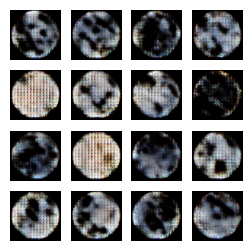

75/75 [==============================] - 30s 403ms/step - d_loss: 1.4743 - g_loss: 1.3199
Epoch 132/500
75/75 [==============================] - 29s 390ms/step - d_loss: 0.9581 - g_loss: 1.0000
Epoch 133/500
75/75 [==============================] - 30s 395ms/step - d_loss: 1.1281 - g_loss: 0.9364
Epoch 134/500
75/75 [==============================] - 29s 390ms/step - d_loss: 0.4128 - g_loss: 1.1979
Epoch 135/500
75/75 [==============================] - 29s 392ms/step - d_loss: 1.3055 - g_loss: 0.9098
Epoch 136/500
75/75 [==============================] - 29s 388ms/step - d_loss: 0.5272 - g_loss: 0.9504
Epoch 137/500
75/75 [==============================] - 29s 387ms/step - d_loss: 1.1403 - g_loss: 0.6488
Epoch 138/500
75/75 [==============================] - 29s 387ms/step - d_loss: 1.1704 - g_loss: 1.0971
Epoch 139/500
75/75 [==============================] - 30s 394ms/step - d_loss: 0.5687 - g_loss: 0.5461
Epoch 140/500
75/75 [==============================] - 29s 389ms/step - d_loss

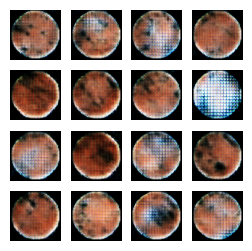

75/75 [==============================] - 29s 389ms/step - d_loss: 0.8959 - g_loss: 0.5056
Epoch 142/500
75/75 [==============================] - 29s 387ms/step - d_loss: 1.0903 - g_loss: 0.8760
Epoch 143/500
75/75 [==============================] - 29s 391ms/step - d_loss: 0.9430 - g_loss: 0.5286
Epoch 144/500
75/75 [==============================] - 29s 388ms/step - d_loss: 0.6180 - g_loss: 0.2995
Epoch 145/500
75/75 [==============================] - 29s 388ms/step - d_loss: 0.8754 - g_loss: 0.9289
Epoch 146/500
75/75 [==============================] - 29s 386ms/step - d_loss: 0.3938 - g_loss: 0.7021
Epoch 147/500
75/75 [==============================] - 29s 389ms/step - d_loss: 1.1537 - g_loss: 0.9720
Epoch 148/500
75/75 [==============================] - 29s 387ms/step - d_loss: 0.2289 - g_loss: 0.1903
Epoch 149/500
75/75 [==============================] - 29s 386ms/step - d_loss: 0.9121 - g_loss: 0.9910
Epoch 150/500
75/75 [==============================] - 29s 390ms/step - d_loss

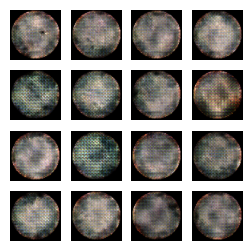

75/75 [==============================] - 29s 389ms/step - d_loss: 0.3750 - g_loss: 0.5290
Epoch 152/500
75/75 [==============================] - 29s 388ms/step - d_loss: 1.0812 - g_loss: 0.7515
Epoch 153/500
75/75 [==============================] - 29s 385ms/step - d_loss: 0.5330 - g_loss: 0.4895
Epoch 154/500
75/75 [==============================] - 29s 386ms/step - d_loss: 0.6575 - g_loss: 1.1499
Epoch 155/500
75/75 [==============================] - 29s 392ms/step - d_loss: 1.2431 - g_loss: 0.8957
Epoch 156/500
75/75 [==============================] - 29s 386ms/step - d_loss: 0.2997 - g_loss: 0.5331
Epoch 157/500
75/75 [==============================] - 29s 386ms/step - d_loss: 0.9163 - g_loss: 0.4313
Epoch 158/500
75/75 [==============================] - 29s 387ms/step - d_loss: 0.8402 - g_loss: 0.6732
Epoch 159/500
75/75 [==============================] - 29s 389ms/step - d_loss: 0.5475 - g_loss: 0.6200
Epoch 160/500
75/75 [==============================] - 29s 386ms/step - d_loss

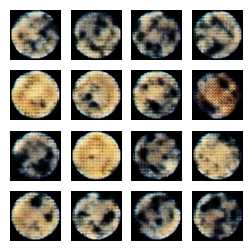

75/75 [==============================] - 29s 388ms/step - d_loss: 0.9400 - g_loss: 0.8059
Epoch 162/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.4565 - g_loss: 0.4264
Epoch 163/500
75/75 [==============================] - 30s 398ms/step - d_loss: 0.9184 - g_loss: 0.8153
Epoch 164/500
75/75 [==============================] - 29s 393ms/step - d_loss: 0.5163 - g_loss: 0.4021
Epoch 165/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.7673 - g_loss: 0.9898
Epoch 166/500
75/75 [==============================] - 30s 396ms/step - d_loss: 0.6233 - g_loss: 0.4003
Epoch 167/500
75/75 [==============================] - 30s 401ms/step - d_loss: 0.6269 - g_loss: 0.8270
Epoch 168/500
75/75 [==============================] - 30s 405ms/step - d_loss: 0.0953 - g_loss: 0.1131
Epoch 169/500
75/75 [==============================] - 30s 405ms/step - d_loss: 0.2651 - g_loss: 0.2969
Epoch 170/500
75/75 [==============================] - 30s 406ms/step - d_loss

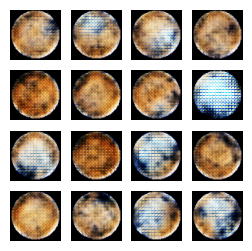

75/75 [==============================] - 30s 405ms/step - d_loss: 0.3999 - g_loss: 0.2084
Epoch 172/500
75/75 [==============================] - 30s 405ms/step - d_loss: 0.6492 - g_loss: 0.3679
Epoch 173/500
75/75 [==============================] - 30s 400ms/step - d_loss: 0.8332 - g_loss: 0.5984
Epoch 174/500
75/75 [==============================] - 30s 401ms/step - d_loss: 0.5444 - g_loss: 0.4109
Epoch 175/500
75/75 [==============================] - 31s 407ms/step - d_loss: 0.2535 - g_loss: 0.0271
Epoch 176/500
75/75 [==============================] - 30s 400ms/step - d_loss: 0.5522 - g_loss: 0.2016
Epoch 177/500
75/75 [==============================] - 29s 385ms/step - d_loss: 0.5187 - g_loss: 0.3906
Epoch 178/500
75/75 [==============================] - 29s 388ms/step - d_loss: 0.1491 - g_loss: 0.0787
Epoch 179/500
75/75 [==============================] - 29s 385ms/step - d_loss: 1.0753 - g_loss: 0.6798
Epoch 180/500
75/75 [==============================] - 29s 386ms/step - d_loss

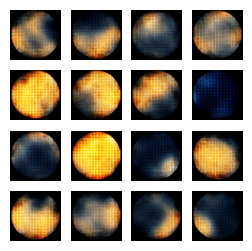

75/75 [==============================] - 29s 386ms/step - d_loss: 0.6633 - g_loss: 0.6111
Epoch 182/500
75/75 [==============================] - 29s 391ms/step - d_loss: 0.5733 - g_loss: 0.2145
Epoch 183/500
75/75 [==============================] - 29s 387ms/step - d_loss: 0.3974 - g_loss: 0.1095
Epoch 184/500
75/75 [==============================] - 29s 387ms/step - d_loss: 0.6860 - g_loss: 0.5378
Epoch 185/500
75/75 [==============================] - 29s 389ms/step - d_loss: 0.8361 - g_loss: 0.7307
Epoch 186/500
75/75 [==============================] - 29s 391ms/step - d_loss: 0.4927 - g_loss: 0.2709
Epoch 187/500
75/75 [==============================] - 29s 389ms/step - d_loss: 0.2756 - g_loss: 0.5537
Epoch 188/500
75/75 [==============================] - 29s 391ms/step - d_loss: 0.5348 - g_loss: 0.1402
Epoch 189/500
75/75 [==============================] - 29s 388ms/step - d_loss: 0.2455 - g_loss: 0.0561
Epoch 190/500
75/75 [==============================] - 29s 389ms/step - d_loss

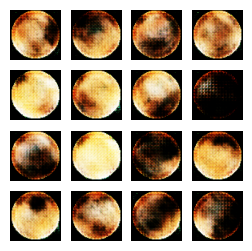

75/75 [==============================] - 29s 392ms/step - d_loss: 0.4026 - g_loss: 0.5819
Epoch 192/500
75/75 [==============================] - 29s 390ms/step - d_loss: 0.2073 - g_loss: 0.1020
Epoch 193/500
75/75 [==============================] - 30s 394ms/step - d_loss: 0.2561 - g_loss: 0.0844
Epoch 194/500
75/75 [==============================] - 29s 388ms/step - d_loss: 0.8733 - g_loss: 0.7557
Epoch 195/500
75/75 [==============================] - 29s 388ms/step - d_loss: 0.5609 - g_loss: 0.2674
Epoch 196/500
75/75 [==============================] - 29s 390ms/step - d_loss: 0.7902 - g_loss: 0.6319
Epoch 197/500
75/75 [==============================] - 29s 387ms/step - d_loss: 0.4361 - g_loss: 0.1444
Epoch 198/500
75/75 [==============================] - 29s 390ms/step - d_loss: 0.5071 - g_loss: 0.2489
Epoch 199/500
75/75 [==============================] - 29s 390ms/step - d_loss: 0.4262 - g_loss: 0.3817
Epoch 200/500
75/75 [==============================] - 29s 388ms/step - d_loss

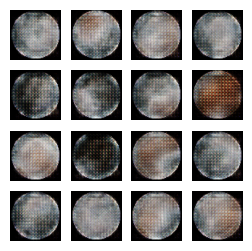

75/75 [==============================] - 29s 389ms/step - d_loss: 0.4859 - g_loss: 0.4466
Epoch 202/500
75/75 [==============================] - 29s 386ms/step - d_loss: 0.3352 - g_loss: 0.2716
Epoch 203/500
75/75 [==============================] - 29s 390ms/step - d_loss: 0.6978 - g_loss: 0.4539
Epoch 204/500
75/75 [==============================] - 29s 385ms/step - d_loss: 0.2398 - g_loss: 0.0512
Epoch 205/500
75/75 [==============================] - 29s 387ms/step - d_loss: 0.5126 - g_loss: 0.3380
Epoch 206/500
75/75 [==============================] - 29s 387ms/step - d_loss: 0.2879 - g_loss: 0.2550
Epoch 207/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.7761 - g_loss: 0.6140
Epoch 208/500
75/75 [==============================] - 29s 385ms/step - d_loss: 0.6132 - g_loss: 0.3274
Epoch 209/500
75/75 [==============================] - 29s 385ms/step - d_loss: 0.4112 - g_loss: 0.1792
Epoch 210/500
75/75 [==============================] - 29s 389ms/step - d_loss

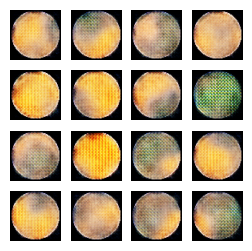

75/75 [==============================] - 29s 389ms/step - d_loss: 0.2143 - g_loss: 0.1604
Epoch 212/500
75/75 [==============================] - 29s 385ms/step - d_loss: 0.0732 - g_loss: 0.0203
Epoch 213/500
75/75 [==============================] - 29s 385ms/step - d_loss: 0.6318 - g_loss: 0.2879
Epoch 214/500
75/75 [==============================] - 29s 384ms/step - d_loss: 0.3380 - g_loss: 0.0695
Epoch 215/500
75/75 [==============================] - 29s 391ms/step - d_loss: 0.5335 - g_loss: 0.3018
Epoch 216/500
75/75 [==============================] - 29s 388ms/step - d_loss: 0.3182 - g_loss: 0.2103
Epoch 217/500
75/75 [==============================] - 29s 388ms/step - d_loss: 0.5769 - g_loss: 0.5933
Epoch 218/500
75/75 [==============================] - 29s 387ms/step - d_loss: 0.6520 - g_loss: 0.4472
Epoch 219/500
75/75 [==============================] - 29s 389ms/step - d_loss: 0.1887 - g_loss: 0.0375
Epoch 220/500
75/75 [==============================] - 29s 386ms/step - d_loss

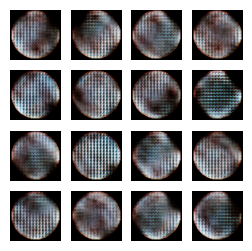

75/75 [==============================] - 29s 388ms/step - d_loss: 0.4700 - g_loss: 0.2923
Epoch 222/500
75/75 [==============================] - 29s 386ms/step - d_loss: 0.2903 - g_loss: 0.1292
Epoch 223/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.4581 - g_loss: 0.4675
Epoch 224/500
75/75 [==============================] - 29s 387ms/step - d_loss: 0.3929 - g_loss: 0.3007
Epoch 225/500
75/75 [==============================] - 29s 387ms/step - d_loss: 0.2820 - g_loss: 0.1940
Epoch 226/500
75/75 [==============================] - 29s 393ms/step - d_loss: 0.8635 - g_loss: 0.3069
Epoch 227/500
75/75 [==============================] - 29s 386ms/step - d_loss: 0.2815 - g_loss: 0.0364
Epoch 228/500
75/75 [==============================] - 29s 386ms/step - d_loss: 0.2313 - g_loss: 0.0832
Epoch 229/500
75/75 [==============================] - 29s 389ms/step - d_loss: 0.3673 - g_loss: 0.3206
Epoch 230/500
75/75 [==============================] - 29s 390ms/step - d_loss

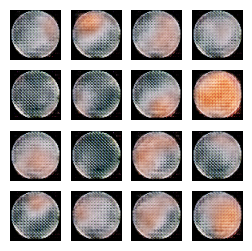

75/75 [==============================] - 29s 389ms/step - d_loss: 0.0456 - g_loss: 0.2618
Epoch 232/500
75/75 [==============================] - 29s 388ms/step - d_loss: -0.0044 - g_loss: 0.0373
Epoch 233/500
75/75 [==============================] - 29s 388ms/step - d_loss: 0.5458 - g_loss: 0.3888
Epoch 234/500
75/75 [==============================] - 29s 386ms/step - d_loss: 0.5938 - g_loss: 0.1630
Epoch 235/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.3932 - g_loss: 0.1289
Epoch 236/500
75/75 [==============================] - 29s 388ms/step - d_loss: 0.1173 - g_loss: 0.0885
Epoch 237/500
75/75 [==============================] - 29s 387ms/step - d_loss: 0.6092 - g_loss: 0.5323
Epoch 238/500
75/75 [==============================] - 29s 386ms/step - d_loss: 0.4306 - g_loss: 0.1462
Epoch 239/500
75/75 [==============================] - 29s 391ms/step - d_loss: 0.4904 - g_loss: 0.3798
Epoch 240/500
75/75 [==============================] - 29s 387ms/step - d_los

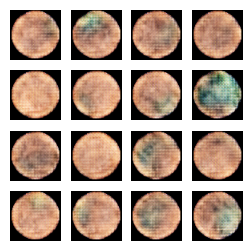

75/75 [==============================] - 29s 389ms/step - d_loss: 0.0588 - g_loss: 0.0093
Epoch 242/500
75/75 [==============================] - 29s 386ms/step - d_loss: 0.3908 - g_loss: 0.0898
Epoch 243/500
75/75 [==============================] - 29s 391ms/step - d_loss: 0.4094 - g_loss: 0.3115
Epoch 244/500
75/75 [==============================] - 29s 387ms/step - d_loss: 0.5706 - g_loss: 0.5620
Epoch 245/500
75/75 [==============================] - 29s 386ms/step - d_loss: 0.3961 - g_loss: 0.3044
Epoch 246/500
75/75 [==============================] - 29s 389ms/step - d_loss: 0.4191 - g_loss: 0.4128
Epoch 247/500
75/75 [==============================] - 29s 387ms/step - d_loss: 0.3145 - g_loss: 0.0430
Epoch 248/500
75/75 [==============================] - 29s 388ms/step - d_loss: 0.2684 - g_loss: 0.1310
Epoch 249/500
75/75 [==============================] - 29s 391ms/step - d_loss: 0.3635 - g_loss: 0.5048
Epoch 250/500
75/75 [==============================] - 29s 387ms/step - d_loss

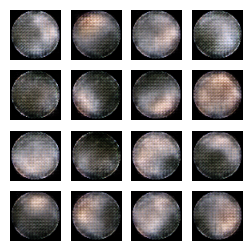

75/75 [==============================] - 29s 389ms/step - d_loss: 0.0631 - g_loss: 0.0250
Epoch 252/500
75/75 [==============================] - 29s 393ms/step - d_loss: 0.5638 - g_loss: 0.5404
Epoch 253/500
75/75 [==============================] - 30s 399ms/step - d_loss: 0.4996 - g_loss: 0.2147
Epoch 254/500
75/75 [==============================] - 31s 408ms/step - d_loss: 0.2418 - g_loss: 0.0306
Epoch 255/500
75/75 [==============================] - 30s 397ms/step - d_loss: 0.2282 - g_loss: 0.0330
Epoch 256/500
75/75 [==============================] - 30s 398ms/step - d_loss: 0.3417 - g_loss: 0.2662
Epoch 257/500
75/75 [==============================] - 30s 399ms/step - d_loss: 0.5346 - g_loss: 0.6264
Epoch 258/500
75/75 [==============================] - 29s 389ms/step - d_loss: 0.2721 - g_loss: 0.1456
Epoch 259/500
75/75 [==============================] - 29s 387ms/step - d_loss: 0.3377 - g_loss: 0.0495
Epoch 260/500
75/75 [==============================] - 29s 386ms/step - d_loss

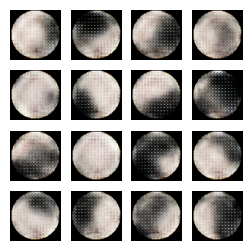

75/75 [==============================] - 29s 393ms/step - d_loss: 0.5798 - g_loss: 0.2401
Epoch 262/500
75/75 [==============================] - 29s 391ms/step - d_loss: 0.3106 - g_loss: 0.2662
Epoch 263/500
75/75 [==============================] - 29s 391ms/step - d_loss: 0.2775 - g_loss: 0.9409
Epoch 264/500
75/75 [==============================] - 29s 393ms/step - d_loss: -0.1036 - g_loss: 1.6505e-04
Epoch 265/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.4908 - g_loss: 0.2301
Epoch 266/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.7503 - g_loss: 0.4098
Epoch 267/500
75/75 [==============================] - 29s 394ms/step - d_loss: 0.3019 - g_loss: 0.0416
Epoch 268/500
75/75 [==============================] - 29s 391ms/step - d_loss: 0.1614 - g_loss: 0.0553
Epoch 269/500
75/75 [==============================] - 29s 391ms/step - d_loss: 0.1148 - g_loss: 0.0301
Epoch 270/500
75/75 [==============================] - 29s 392ms/step - d

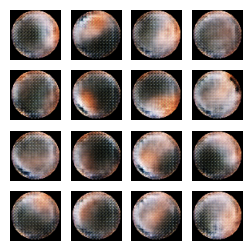

75/75 [==============================] - 30s 397ms/step - d_loss: 0.8132 - g_loss: 0.7226
Epoch 272/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.6921 - g_loss: 0.6968
Epoch 273/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.7174 - g_loss: 0.6054
Epoch 274/500
75/75 [==============================] - 29s 394ms/step - d_loss: 0.7045 - g_loss: 0.6439
Epoch 275/500
75/75 [==============================] - 29s 393ms/step - d_loss: 0.6629 - g_loss: 0.7567
Epoch 276/500
75/75 [==============================] - 30s 405ms/step - d_loss: 0.4627 - g_loss: 0.3301
Epoch 277/500
75/75 [==============================] - 30s 404ms/step - d_loss: 0.1546 - g_loss: 0.1439
Epoch 278/500
75/75 [==============================] - 30s 404ms/step - d_loss: 0.1338 - g_loss: 0.2438
Epoch 279/500
75/75 [==============================] - 30s 405ms/step - d_loss: 0.3421 - g_loss: 0.4262
Epoch 280/500
75/75 [==============================] - 30s 401ms/step - d_loss

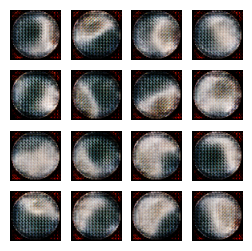

75/75 [==============================] - 29s 394ms/step - d_loss: 0.0369 - g_loss: 0.0409
Epoch 282/500
75/75 [==============================] - 29s 391ms/step - d_loss: 0.1888 - g_loss: 0.0880
Epoch 283/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.6004 - g_loss: 0.7927
Epoch 284/500
75/75 [==============================] - 30s 398ms/step - d_loss: 0.2601 - g_loss: 0.0622
Epoch 285/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.3839 - g_loss: 0.4804
Epoch 286/500
75/75 [==============================] - 29s 391ms/step - d_loss: 0.1322 - g_loss: 0.0656
Epoch 287/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.1400 - g_loss: 0.0763
Epoch 288/500
75/75 [==============================] - 29s 391ms/step - d_loss: 0.1248 - g_loss: 0.2056
Epoch 289/500
75/75 [==============================] - 29s 390ms/step - d_loss: 0.1755 - g_loss: 0.1450
Epoch 290/500
75/75 [==============================] - 29s 390ms/step - d_loss

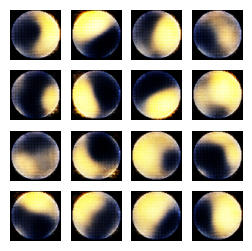

75/75 [==============================] - 30s 395ms/step - d_loss: 0.6452 - g_loss: 0.2873
Epoch 292/500
75/75 [==============================] - 29s 390ms/step - d_loss: 0.4165 - g_loss: 0.2874
Epoch 293/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.5534 - g_loss: 0.7795
Epoch 294/500
75/75 [==============================] - 29s 391ms/step - d_loss: 0.5292 - g_loss: 0.5753
Epoch 295/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.1449 - g_loss: 0.1047
Epoch 296/500
75/75 [==============================] - 30s 398ms/step - d_loss: 0.3443 - g_loss: 0.5447
Epoch 297/500
75/75 [==============================] - 29s 393ms/step - d_loss: 0.1851 - g_loss: 0.1323
Epoch 298/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.3040 - g_loss: 0.2328
Epoch 299/500
75/75 [==============================] - 30s 394ms/step - d_loss: 0.3112 - g_loss: 0.5467
Epoch 300/500
75/75 [==============================] - 29s 392ms/step - d_loss

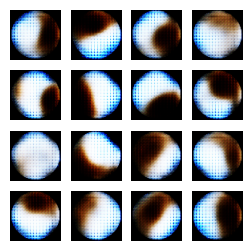

75/75 [==============================] - 30s 395ms/step - d_loss: 0.6381 - g_loss: 0.9612
Epoch 302/500
75/75 [==============================] - 29s 393ms/step - d_loss: 0.2098 - g_loss: 0.4654
Epoch 303/500
75/75 [==============================] - 29s 393ms/step - d_loss: 0.2487 - g_loss: 0.1141
Epoch 304/500
75/75 [==============================] - 30s 398ms/step - d_loss: -0.0027 - g_loss: 0.0327
Epoch 305/500
75/75 [==============================] - 30s 397ms/step - d_loss: -0.0356 - g_loss: 0.0417
Epoch 306/500
75/75 [==============================] - 30s 401ms/step - d_loss: 0.2706 - g_loss: 0.5985
Epoch 307/500
75/75 [==============================] - 30s 405ms/step - d_loss: 0.3951 - g_loss: 0.1927
Epoch 308/500
75/75 [==============================] - 30s 403ms/step - d_loss: 0.2007 - g_loss: 0.2937
Epoch 309/500
75/75 [==============================] - 30s 403ms/step - d_loss: 0.3458 - g_loss: 0.6172
Epoch 310/500
75/75 [==============================] - 30s 403ms/step - d_lo

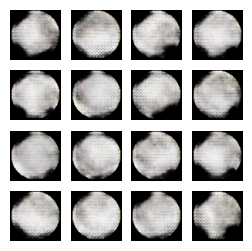

75/75 [==============================] - 31s 409ms/step - d_loss: 0.0840 - g_loss: 0.1736
Epoch 312/500
75/75 [==============================] - 30s 401ms/step - d_loss: 0.1960 - g_loss: 0.1581
Epoch 313/500
75/75 [==============================] - 30s 404ms/step - d_loss: 0.0867 - g_loss: 0.4830
Epoch 314/500
75/75 [==============================] - 30s 401ms/step - d_loss: -0.0830 - g_loss: 0.0449
Epoch 315/500
75/75 [==============================] - 30s 402ms/step - d_loss: 0.2726 - g_loss: 0.0558
Epoch 316/500
75/75 [==============================] - 30s 401ms/step - d_loss: 0.5667 - g_loss: 0.2850
Epoch 317/500
75/75 [==============================] - 30s 405ms/step - d_loss: 0.3742 - g_loss: 0.3139
Epoch 318/500
75/75 [==============================] - 30s 402ms/step - d_loss: 0.3184 - g_loss: 0.1992
Epoch 319/500
75/75 [==============================] - 30s 402ms/step - d_loss: 0.1543 - g_loss: 0.0320
Epoch 320/500
75/75 [==============================] - 30s 405ms/step - d_los

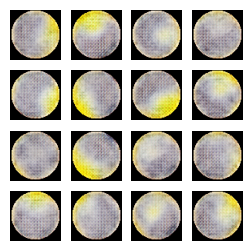

75/75 [==============================] - 30s 404ms/step - d_loss: -0.0726 - g_loss: 0.1002
Epoch 322/500
75/75 [==============================] - 30s 403ms/step - d_loss: -0.1351 - g_loss: 0.0934
Epoch 323/500
75/75 [==============================] - 30s 402ms/step - d_loss: 0.7763 - g_loss: 0.5086
Epoch 324/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.3116 - g_loss: 0.2217
Epoch 325/500
75/75 [==============================] - 30s 400ms/step - d_loss: 0.0567 - g_loss: 0.4765
Epoch 326/500
75/75 [==============================] - 30s 394ms/step - d_loss: 0.3523 - g_loss: 0.1359
Epoch 327/500
75/75 [==============================] - 29s 393ms/step - d_loss: 0.6083 - g_loss: 0.3682
Epoch 328/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.3601 - g_loss: 0.4911
Epoch 329/500
75/75 [==============================] - 30s 396ms/step - d_loss: 0.2570 - g_loss: 0.4942
Epoch 330/500
75/75 [==============================] - 29s 393ms/step - d_lo

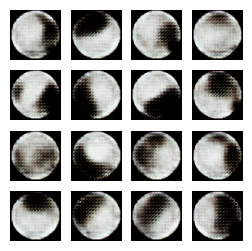

75/75 [==============================] - 30s 395ms/step - d_loss: 0.1411 - g_loss: 0.0853
Epoch 332/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.1566 - g_loss: 0.3329
Epoch 333/500
75/75 [==============================] - 30s 400ms/step - d_loss: 0.0400 - g_loss: 0.0261
Epoch 334/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.2394 - g_loss: 0.3647
Epoch 335/500
75/75 [==============================] - 29s 393ms/step - d_loss: -0.0391 - g_loss: 0.0554
Epoch 336/500
75/75 [==============================] - 30s 395ms/step - d_loss: 0.1688 - g_loss: 0.3934
Epoch 337/500
75/75 [==============================] - 29s 391ms/step - d_loss: 0.1169 - g_loss: 0.0450
Epoch 338/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.0328 - g_loss: 0.0317
Epoch 339/500
75/75 [==============================] - 29s 394ms/step - d_loss: 0.1831 - g_loss: 0.1121
Epoch 340/500
75/75 [==============================] - 30s 397ms/step - d_los

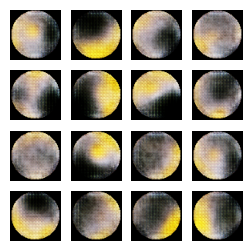

75/75 [==============================] - 30s 395ms/step - d_loss: 0.4935 - g_loss: 0.6756
Epoch 342/500
75/75 [==============================] - 30s 396ms/step - d_loss: 0.3191 - g_loss: 0.4332
Epoch 343/500
75/75 [==============================] - 30s 394ms/step - d_loss: 0.1394 - g_loss: 0.0388
Epoch 344/500
75/75 [==============================] - 30s 395ms/step - d_loss: 0.3303 - g_loss: 0.5259
Epoch 345/500
75/75 [==============================] - 30s 401ms/step - d_loss: 0.1697 - g_loss: 0.1993
Epoch 346/500
75/75 [==============================] - 29s 393ms/step - d_loss: 0.1921 - g_loss: 0.0479
Epoch 347/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.1355 - g_loss: 0.1084
Epoch 348/500
75/75 [==============================] - 30s 395ms/step - d_loss: 0.2963 - g_loss: 0.3376
Epoch 349/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.1425 - g_loss: 0.5581
Epoch 350/500
75/75 [==============================] - 29s 393ms/step - d_loss

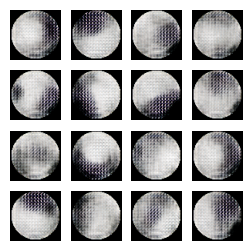

75/75 [==============================] - 30s 394ms/step - d_loss: 0.2201 - g_loss: 0.2048
Epoch 352/500
75/75 [==============================] - 29s 393ms/step - d_loss: 0.0953 - g_loss: 0.1327
Epoch 353/500
75/75 [==============================] - 30s 398ms/step - d_loss: -0.1044 - g_loss: 0.0176
Epoch 354/500
75/75 [==============================] - 29s 393ms/step - d_loss: 1.0776 - g_loss: 1.8581
Epoch 355/500
75/75 [==============================] - 30s 401ms/step - d_loss: 0.1817 - g_loss: 0.1607
Epoch 356/500
75/75 [==============================] - 30s 404ms/step - d_loss: 0.1365 - g_loss: 0.0650
Epoch 357/500
75/75 [==============================] - 30s 403ms/step - d_loss: 0.1132 - g_loss: 0.0335
Epoch 358/500
75/75 [==============================] - 30s 402ms/step - d_loss: 0.1161 - g_loss: 0.0345
Epoch 359/500
75/75 [==============================] - 30s 405ms/step - d_loss: 0.1710 - g_loss: 0.1292
Epoch 360/500
75/75 [==============================] - 30s 402ms/step - d_los

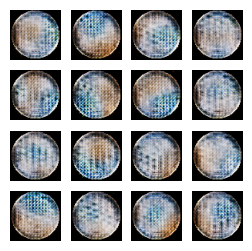

75/75 [==============================] - 30s 403ms/step - d_loss: -0.0965 - g_loss: 0.0222
Epoch 362/500
75/75 [==============================] - 30s 405ms/step - d_loss: 0.0275 - g_loss: 0.1059
Epoch 363/500
75/75 [==============================] - 31s 409ms/step - d_loss: 0.4512 - g_loss: 0.4231
Epoch 364/500
75/75 [==============================] - 30s 403ms/step - d_loss: 0.5631 - g_loss: 0.2853
Epoch 365/500
75/75 [==============================] - 30s 402ms/step - d_loss: 0.1270 - g_loss: 0.0571
Epoch 366/500
75/75 [==============================] - 30s 401ms/step - d_loss: 0.6089 - g_loss: 0.6581
Epoch 367/500
75/75 [==============================] - 30s 404ms/step - d_loss: 0.6332 - g_loss: 0.2214
Epoch 368/500
75/75 [==============================] - 30s 401ms/step - d_loss: 0.3938 - g_loss: 0.2448
Epoch 369/500
75/75 [==============================] - 30s 401ms/step - d_loss: 0.3910 - g_loss: 0.7342
Epoch 370/500
75/75 [==============================] - 30s 405ms/step - d_los

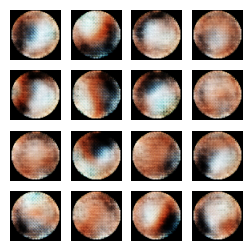

75/75 [==============================] - 30s 404ms/step - d_loss: 0.1814 - g_loss: 0.0502
Epoch 372/500
75/75 [==============================] - 30s 402ms/step - d_loss: 0.3118 - g_loss: 0.3622
Epoch 373/500
75/75 [==============================] - 30s 403ms/step - d_loss: 0.3066 - g_loss: 0.6737
Epoch 374/500
75/75 [==============================] - 30s 403ms/step - d_loss: 0.7150 - g_loss: 0.7095
Epoch 375/500
75/75 [==============================] - 31s 410ms/step - d_loss: 0.6328 - g_loss: 0.7321
Epoch 376/500
75/75 [==============================] - 30s 404ms/step - d_loss: 0.7664 - g_loss: 0.6972
Epoch 377/500
75/75 [==============================] - 30s 405ms/step - d_loss: 0.8308 - g_loss: 0.5480
Epoch 378/500
75/75 [==============================] - 30s 405ms/step - d_loss: 0.5273 - g_loss: 0.2686
Epoch 379/500
75/75 [==============================] - 31s 407ms/step - d_loss: 0.2788 - g_loss: 0.6030
Epoch 380/500
75/75 [==============================] - 30s 406ms/step - d_loss

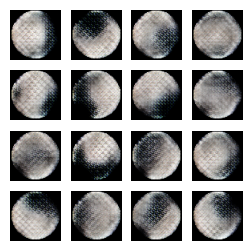

75/75 [==============================] - 30s 406ms/step - d_loss: 0.1826 - g_loss: 0.0976
Epoch 382/500
75/75 [==============================] - 30s 405ms/step - d_loss: 0.2764 - g_loss: 0.5117
Epoch 383/500
75/75 [==============================] - 31s 412ms/step - d_loss: 0.5835 - g_loss: 0.3326
Epoch 384/500
75/75 [==============================] - 30s 404ms/step - d_loss: 0.3040 - g_loss: 0.2009
Epoch 385/500
75/75 [==============================] - 30s 405ms/step - d_loss: 0.4170 - g_loss: 1.4642
Epoch 386/500
75/75 [==============================] - 31s 408ms/step - d_loss: 0.1474 - g_loss: 0.0900
Epoch 387/500
75/75 [==============================] - 30s 402ms/step - d_loss: 0.0229 - g_loss: 0.0458
Epoch 388/500
75/75 [==============================] - 30s 404ms/step - d_loss: 0.1428 - g_loss: 0.0755
Epoch 389/500
75/75 [==============================] - 30s 402ms/step - d_loss: 0.2444 - g_loss: 0.4086
Epoch 390/500
75/75 [==============================] - 30s 407ms/step - d_loss

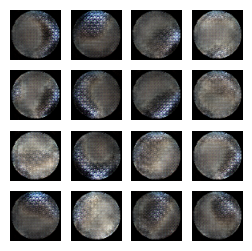

75/75 [==============================] - 30s 404ms/step - d_loss: 0.2651 - g_loss: 0.1603
Epoch 392/500
75/75 [==============================] - 30s 403ms/step - d_loss: 0.5963 - g_loss: 1.0766
Epoch 393/500
75/75 [==============================] - 30s 404ms/step - d_loss: 0.1029 - g_loss: 0.0383
Epoch 394/500
75/75 [==============================] - 30s 404ms/step - d_loss: -0.0365 - g_loss: 0.0610
Epoch 395/500
75/75 [==============================] - 30s 403ms/step - d_loss: 0.1985 - g_loss: 0.4419
Epoch 396/500
75/75 [==============================] - 29s 394ms/step - d_loss: 0.1243 - g_loss: 0.1975
Epoch 397/500
75/75 [==============================] - 30s 394ms/step - d_loss: -0.1364 - g_loss: 0.0149
Epoch 398/500
75/75 [==============================] - 30s 396ms/step - d_loss: -0.1335 - g_loss: 0.0327
Epoch 399/500
75/75 [==============================] - 30s 394ms/step - d_loss: 0.8258 - g_loss: 1.5256
Epoch 400/500
75/75 [==============================] - 30s 394ms/step - d_l

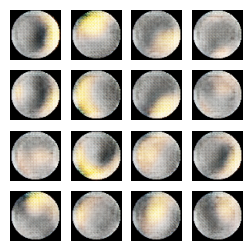

75/75 [==============================] - 30s 396ms/step - d_loss: 0.2036 - g_loss: 0.3063
Epoch 402/500
75/75 [==============================] - 30s 404ms/step - d_loss: -0.0172 - g_loss: 0.0075
Epoch 403/500
75/75 [==============================] - 30s 398ms/step - d_loss: 0.1695 - g_loss: 0.0635
Epoch 404/500
75/75 [==============================] - 30s 396ms/step - d_loss: 0.5479 - g_loss: 0.9683
Epoch 405/500
75/75 [==============================] - 30s 395ms/step - d_loss: 0.2531 - g_loss: 0.1259
Epoch 406/500
75/75 [==============================] - 30s 394ms/step - d_loss: 0.1240 - g_loss: 0.0509
Epoch 407/500
75/75 [==============================] - 30s 394ms/step - d_loss: -0.0438 - g_loss: 0.0560
Epoch 408/500
75/75 [==============================] - 30s 397ms/step - d_loss: 0.1873 - g_loss: 0.6106
Epoch 409/500
75/75 [==============================] - 30s 394ms/step - d_loss: 0.1098 - g_loss: 0.3600
Epoch 410/500
75/75 [==============================] - 30s 395ms/step - d_lo

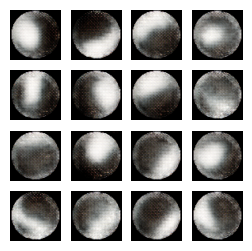

75/75 [==============================] - 30s 396ms/step - d_loss: 0.5151 - g_loss: 0.7374
Epoch 412/500
75/75 [==============================] - 30s 396ms/step - d_loss: 0.6509 - g_loss: 0.4433
Epoch 413/500
75/75 [==============================] - 30s 402ms/step - d_loss: 0.5779 - g_loss: 0.6139
Epoch 414/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.3001 - g_loss: 0.2032
Epoch 415/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.5875 - g_loss: 0.3798
Epoch 416/500
75/75 [==============================] - 30s 396ms/step - d_loss: 0.4534 - g_loss: 0.3577
Epoch 417/500
75/75 [==============================] - 29s 392ms/step - d_loss: 0.1732 - g_loss: 0.7068
Epoch 418/500
75/75 [==============================] - 29s 392ms/step - d_loss: -0.0967 - g_loss: 0.0713
Epoch 419/500
75/75 [==============================] - 30s 395ms/step - d_loss: 0.0783 - g_loss: 0.1396
Epoch 420/500
75/75 [==============================] - 29s 393ms/step - d_los

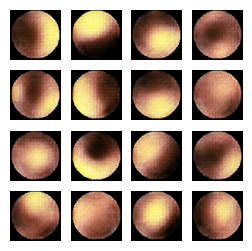

75/75 [==============================] - 30s 395ms/step - d_loss: 0.3036 - g_loss: 0.4338
Epoch 422/500
75/75 [==============================] - 29s 393ms/step - d_loss: 0.2665 - g_loss: 0.5745
Epoch 423/500
75/75 [==============================] - 30s 395ms/step - d_loss: 0.0729 - g_loss: 0.0851
Epoch 424/500
75/75 [==============================] - 30s 400ms/step - d_loss: 0.1574 - g_loss: 0.3267
Epoch 425/500
75/75 [==============================] - 29s 393ms/step - d_loss: 0.3377 - g_loss: 0.2059
Epoch 426/500
75/75 [==============================] - 30s 394ms/step - d_loss: 0.2164 - g_loss: 0.1636
Epoch 427/500
75/75 [==============================] - 30s 396ms/step - d_loss: 0.4947 - g_loss: 0.9217
Epoch 428/500
75/75 [==============================] - 29s 394ms/step - d_loss: 0.5513 - g_loss: 0.6020
Epoch 429/500
75/75 [==============================] - 30s 394ms/step - d_loss: 0.4290 - g_loss: 0.4154
Epoch 430/500
75/75 [==============================] - 30s 394ms/step - d_loss

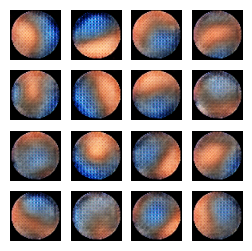

75/75 [==============================] - 30s 400ms/step - d_loss: 0.3534 - g_loss: 0.2768
Epoch 432/500
75/75 [==============================] - 30s 395ms/step - d_loss: 0.5946 - g_loss: 1.1062
Epoch 433/500
75/75 [==============================] - 30s 396ms/step - d_loss: 0.1434 - g_loss: 0.2056
Epoch 434/500
75/75 [==============================] - 30s 398ms/step - d_loss: 0.1497 - g_loss: 0.2528
Epoch 435/500
75/75 [==============================] - 30s 397ms/step - d_loss: 0.1892 - g_loss: 0.3401
Epoch 436/500
75/75 [==============================] - 30s 403ms/step - d_loss: 0.3058 - g_loss: 0.3228
Epoch 437/500
75/75 [==============================] - 29s 393ms/step - d_loss: 0.4393 - g_loss: 0.8395
Epoch 438/500
75/75 [==============================] - 30s 394ms/step - d_loss: 0.5290 - g_loss: 0.9973
Epoch 439/500
75/75 [==============================] - 30s 397ms/step - d_loss: 0.3235 - g_loss: 0.2320
Epoch 440/500
75/75 [==============================] - 30s 394ms/step - d_loss

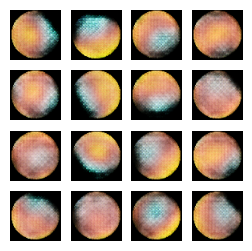

75/75 [==============================] - 30s 396ms/step - d_loss: 0.4652 - g_loss: 0.9181
Epoch 442/500
75/75 [==============================] - 30s 395ms/step - d_loss: 0.1308 - g_loss: 0.1131
Epoch 443/500
75/75 [==============================] - 30s 395ms/step - d_loss: 0.0560 - g_loss: 0.1810
Epoch 444/500
75/75 [==============================] - 30s 401ms/step - d_loss: 0.3719 - g_loss: 1.1601
Epoch 445/500
75/75 [==============================] - 29s 393ms/step - d_loss: 0.4066 - g_loss: 0.2539
Epoch 446/500
75/75 [==============================] - 30s 394ms/step - d_loss: 0.2528 - g_loss: 0.1519
Epoch 447/500
75/75 [==============================] - 30s 401ms/step - d_loss: 0.1791 - g_loss: 0.6370
Epoch 448/500
75/75 [==============================] - 30s 404ms/step - d_loss: -0.1489 - g_loss: 0.2209
Epoch 449/500
75/75 [==============================] - 31s 408ms/step - d_loss: 0.2241 - g_loss: 0.2776
Epoch 450/500
75/75 [==============================] - 30s 407ms/step - d_los

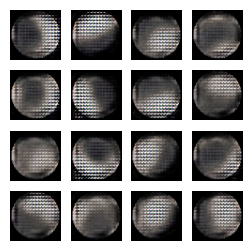

75/75 [==============================] - 31s 412ms/step - d_loss: 0.1550 - g_loss: 0.6314
Epoch 452/500
75/75 [==============================] - 30s 404ms/step - d_loss: 0.1707 - g_loss: 0.7237
Epoch 453/500
75/75 [==============================] - 30s 403ms/step - d_loss: 0.0366 - g_loss: 0.0739
Epoch 454/500
75/75 [==============================] - 30s 403ms/step - d_loss: -0.0481 - g_loss: 0.0672
Epoch 455/500
75/75 [==============================] - 30s 405ms/step - d_loss: -0.0121 - g_loss: 0.1955
Epoch 456/500
75/75 [==============================] - 30s 404ms/step - d_loss: 0.1345 - g_loss: 0.7239
Epoch 457/500
75/75 [==============================] - 31s 407ms/step - d_loss: 0.1409 - g_loss: 0.3838
Epoch 458/500
75/75 [==============================] - 30s 399ms/step - d_loss: 0.0519 - g_loss: 1.1309
Epoch 459/500
75/75 [==============================] - 30s 395ms/step - d_loss: 0.3824 - g_loss: 0.5492
Epoch 460/500
75/75 [==============================] - 30s 397ms/step - d_lo

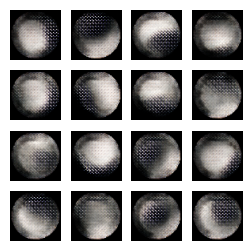

75/75 [==============================] - 30s 395ms/step - d_loss: 0.2605 - g_loss: 1.0947
Epoch 462/500
75/75 [==============================] - 29s 394ms/step - d_loss: 0.3044 - g_loss: 0.3562
Epoch 463/500
75/75 [==============================] - 30s 394ms/step - d_loss: 0.4672 - g_loss: 0.5209
Epoch 464/500
75/75 [==============================] - 30s 394ms/step - d_loss: 0.3411 - g_loss: 0.6780
Epoch 465/500
75/75 [==============================] - 30s 400ms/step - d_loss: 0.3049 - g_loss: 0.1570
Epoch 466/500
75/75 [==============================] - 30s 397ms/step - d_loss: 0.0090 - g_loss: 0.2721
Epoch 467/500
75/75 [==============================] - 30s 395ms/step - d_loss: 0.2942 - g_loss: 1.0191
Epoch 468/500
75/75 [==============================] - 30s 399ms/step - d_loss: 0.1322 - g_loss: 0.1489
Epoch 469/500
75/75 [==============================] - 30s 399ms/step - d_loss: 0.2463 - g_loss: 0.7637
Epoch 470/500
75/75 [==============================] - 30s 394ms/step - d_loss

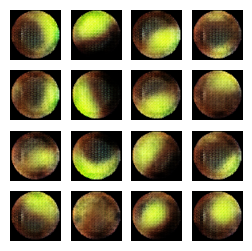

75/75 [==============================] - 30s 397ms/step - d_loss: 0.2476 - g_loss: 0.4905
Epoch 472/500
75/75 [==============================] - 30s 394ms/step - d_loss: 0.0930 - g_loss: 0.2517
Epoch 473/500
75/75 [==============================] - 30s 402ms/step - d_loss: 0.2987 - g_loss: 0.7417
Epoch 474/500
75/75 [==============================] - 30s 395ms/step - d_loss: 0.2298 - g_loss: 0.4756
Epoch 475/500
75/75 [==============================] - 30s 394ms/step - d_loss: 0.2083 - g_loss: 0.3657
Epoch 476/500
75/75 [==============================] - 30s 397ms/step - d_loss: 0.6458 - g_loss: 2.2511
Epoch 477/500
75/75 [==============================] - 30s 394ms/step - d_loss: 0.0269 - g_loss: 0.0771
Epoch 478/500
75/75 [==============================] - 30s 395ms/step - d_loss: -0.0514 - g_loss: 0.1077
Epoch 479/500
75/75 [==============================] - 30s 395ms/step - d_loss: 0.2813 - g_loss: 0.9031
Epoch 480/500
75/75 [==============================] - 30s 399ms/step - d_los

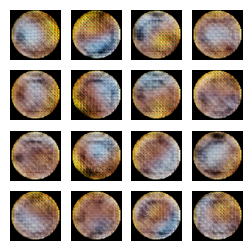

75/75 [==============================] - 30s 399ms/step - d_loss: 0.0014 - g_loss: 0.4680
Epoch 482/500
75/75 [==============================] - 30s 397ms/step - d_loss: 0.3535 - g_loss: 1.0989
Epoch 483/500
75/75 [==============================] - 30s 396ms/step - d_loss: 0.5151 - g_loss: 0.5636
Epoch 484/500
75/75 [==============================] - 30s 398ms/step - d_loss: 0.4045 - g_loss: 0.7100
Epoch 485/500
75/75 [==============================] - 30s 406ms/step - d_loss: 0.4847 - g_loss: 0.6919
Epoch 486/500
75/75 [==============================] - 29s 393ms/step - d_loss: 0.5560 - g_loss: 0.6106
Epoch 487/500
75/75 [==============================] - 29s 394ms/step - d_loss: 0.2253 - g_loss: 0.7501
Epoch 488/500
75/75 [==============================] - 30s 396ms/step - d_loss: 0.4193 - g_loss: 1.1438
Epoch 489/500
75/75 [==============================] - 30s 394ms/step - d_loss: 0.0491 - g_loss: 0.0507
Epoch 490/500
75/75 [==============================] - 30s 395ms/step - d_loss

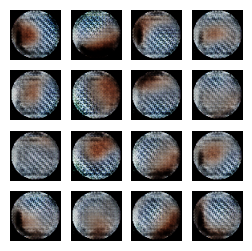

75/75 [==============================] - 30s 397ms/step - d_loss: 0.3268 - g_loss: 0.9533
Epoch 492/500
75/75 [==============================] - 30s 395ms/step - d_loss: 0.2552 - g_loss: 0.6692
Epoch 493/500
75/75 [==============================] - 30s 401ms/step - d_loss: 0.3810 - g_loss: 0.6407
Epoch 494/500
75/75 [==============================] - 29s 394ms/step - d_loss: 0.4034 - g_loss: 0.4855
Epoch 495/500
75/75 [==============================] - 30s 400ms/step - d_loss: 0.5267 - g_loss: 0.8868
Epoch 496/500
75/75 [==============================] - 30s 395ms/step - d_loss: 0.5126 - g_loss: 0.7553
Epoch 497/500
75/75 [==============================] - 30s 395ms/step - d_loss: 0.3909 - g_loss: 0.5993
Epoch 498/500
75/75 [==============================] - 30s 395ms/step - d_loss: 0.0419 - g_loss: 0.1404
Epoch 499/500
75/75 [==============================] - 30s 399ms/step - d_loss: 0.3689 - g_loss: 0.9808
Epoch 500/500
75/75 [==============================] - 30s 397ms/step - d_loss

In [25]:
# number of epochs
NUM_EPOCHS = 500 

dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])

# Deployment

Tworzenie gifa z wyników generowania planet w każdej epoce

In [26]:
import glob
import contextlib
from PIL import Image

# filepaths
fp_in = "./results_064_v2/*.jpg"
fp_out = "./results_064_v2/epochs64_v2.gif"

# use exit stack to automatically close opened images
with contextlib.ExitStack() as stack:

    # lazily load images
    imgs = (stack.enter_context(Image.open(f))
            for f in sorted(glob.glob(fp_in)))

    # extract  first image from iterator
    img = next(imgs)

    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=1, loop=0)